<a href="https://colab.research.google.com/github/alexandre-bismuth/UncertaintyInDeepLearning/blob/main/UDL_Practical_1_Setting_a_Basline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UDL Practical 1 - Setting A Baseline
In this practical we'll go over several concepts you've likely encountered in your life as a machine learning researcher but with a different, more principled point of view. This will help you use and think about these concepts, both during the course and more broadly over the course of your research.

Typically we have some data $D$, pertaining to something in the world, and a model $M$ that we want to describe it. Here "describe" means effectively model it in a way that helps us make meaningful predictions about the world - is this a picture of a cat? Where should a car drive given a certain intersection? and so on and so on. We want to get the model that best describes the world, which if we're being rational, is given by $P(M|D)$.

To connect it to quantities we're familiar with, using Bayes rule we have that
$$
P(M|D) = \frac{P(D|M) P(M)}{P(D)}
$$
or
$$
\text{Posterior} = \frac{\text{Likelihood}\cdot\text{Prior}}{\text{Evidence}}
$$


---
**Q0:** we often talk about modelling the world yet here we have a distribution over models, $P(M|D)$, not a single one - what's our model here? Why would we want an entire distribution and not a specific one?

**A:** We use a distribution of models and not a single model because, given some data, we may have a lot of uncertainty as to which model is generating it. Therefore, each model has a probability of existing and we use an entire distribution.

---

If we have no special prior over the models, so $P(M)$ is constant, the posterior distribution simply equals the likelihood:
$$
P(M|D) \propto P(D|M)
$$
whereas otherwise we need to take it into account:
$$
P(M|D) \propto P(D|M)P(M)
$$
The latter can penalize extremely unlikely models by incorporating information from our prior $P(M)$.

Assuming we managed to find the distribution over models given some data - easier said than done! - we usually want to make predictions about new data $D^* = \{(x^*, y^*)\}$.

---
**Q1:** a much easier alternative, albeit an inexact one, is finding a single model that maximizes our posterior. What is this called for each of the two cases outlined above - when our prior is uniform and when it isn't? These are common machine learning terms but you may have not encountered them yet.

**A:**
1. In the case where we have no special prior over the models, so $P(M)$ is constant, maximizing the posterior $P(M|D) \propto P(D|M)$ is equivalent to finding the maximum likelihood estimator for $P(D|M)$.
2. In the case where $P(M)$ is not constant, we want to maximize $P(M|D) \propto P(D|M)P(M)$. This is called maximum a posteriori estimation.

---

 Ideally we would consider all possible models instead of just one, that way we can take our uncertainty in each into account. For example, if you're driving and see a large bus, you'd take into account both the case where a kid is about to pop out from behind it and the case when there isn't instead of immediately committing to one.

 In practice, this is done by weighing how well the new data is also explained by these models, giving the predictive distribution
$$
P(y^*|x^*, D) = \int P(y^*|x^*, M) P(M|D) dM
$$

In practice this is difficult due to several reasons. One reason is that it's extremely hard to calculate $P(D)$ in general, as we'd have to calculate over all possible models - and so analytically calculating the predictive distribution is often impossible. More on this later!

## Part A - Weight Decay and Maximum A Posteriori Estimation

When doing Maximum Likelihood Estimation (MLE), we approximate the posterior distribution with $P(M|D) \propto P(D|M)$, and find our model weights using this distribution. Let's illustrate this using a simple linear regression example.

---
**Q2:** derive from first principles the MLE solution for linear regression. To break it into steps:  
a. Assume you have data $\{(x_i,y_i)\}_{i=1}^N$, where $x_i$ are vectors of features of length $d$. You can denote the $x$s stacked into a matrix of size $n\times d$ as $X$. Assuming the data was generated using Gaussian noise with variance $\sigma^2$, what's $P(y|x,w)$, where $w$ is the linear regression's weights? You can assume there's no bias.  
b. What's $P(Y|X,w)$? $Y$ is similarly a vector of length $N$ of all $y_i$.  
c. Find the log-likelihood by taking the log of (b). If we want to find $w$ what loss function are we effectively optimising?  
d. Analytically find $w$ by taking the gradient of (c) and setting it to zero.

It's okay to answer this question quickly if you've already done this, as long as you do it right :)

**A:**
a. Here, we simply have to follow a Gaussian distribution. Since the data was generated using Gaussian noise with variance $\sigma^2$, the probability of observing $y_i$ given $x_i$ and weights $w$ is:
$$ P(y_i|x_i,w) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(y_i - x_i^T w)^2}{2\sigma^2}\right)$$

b. Since each data point is independent, the probability of observing the entire vector $Y$ given the matrix $X$ and weights $w$ is the product of the individual probabilities:
$$ P(Y|X,w) = \prod_{i=1}^N P(y_i|x_i,w) = \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(y_i - x_i^T w)^2}{2\sigma^2}\right) = \left(\frac{1}{2\pi\sigma^2}\right)^{N/2} \exp\left(-\sum_{i=1}^N \frac{(y_i - x_i^T w)^2}{2\sigma^2}\right)
$$

c. The log-likelihood can be obtained by taking the log of (b) as follows:
$$\log \left( P(Y|X,w) \right) = \log \left[ \left(\frac{1}{2\pi\sigma^2}\right)^{N/2} \exp\left(-\sum_{i=1}^N \frac{(y_i - x_i^T w)^2}{2\sigma^2}\right) \right] \\ = \frac{-N}{2} \log(2\pi \sigma^2) - \sum_{i=1}^N \frac{(y_i - x_i^T w)^2}{2\sigma^2}$$

Here, we can see that this is equivalent to optimising for the residual sum of square loss function (with some added constants which don't interefere with the minimum).

d. We first have to find the gradient of $\log \left( P(Y|X,w) \right)$. We can already say the first constant term has a derviative of zero, so we can ignore it.

Then, we can take the $\frac{-1}{2\sigma^2}$ and take it out of the sum to make it a constant that will scale the derivative by at the end.

We thus only have to consider the sum and calculate the derivative with respect to $w$:
$$\left(\sum_{i=1}^N (y_i - x_i^T w)^2 \right)' = 2 \sum_{i=1}^N (y_i - x_i^T w)'(y_i - x_i^T w) = -2 \sum_{i=1}^N x_i(y_i - x_i^T w) $$

We can thus conclude by saying that the derivative of the log of (b) is
$$\frac{1}{\sigma^2}\sum_{i=1}^N x_i(y_i - x_i^T w)$$

Setting it to 0, we get that we must have $ x_i(y_i - x_i^T w) = 0$ for all values of i. Therefore, in matrix form, that gives $X(Y-X^Tw) = 0$. This can then be rewritten as $X^TY - XX^Tw = 0$ which finally gives $w = (X^TX)^{-1} X^TY$ .

---

The case above find the MLE linear regressor. Now, let's try penalizing complex models by incorporating a prior over our weights. We typically want simpler models, which is an instance of what's known as _Occam's Razor_ - a simpler explanation is often better than a complex one. Here we can do this by assuming our weights have some prior distribution, e.g. a Gaussian with zero mean and some variance $\tau^2$.

---
**Q3:** let's quickly repeat the previous derivation but now with the new prior. Again, taking it step by step:  
a. What's the posterior distribution over the weights, given this prior?  
b. Taking the log, what's the loss function we're optimising here?  
c. Analytically find $w$ by taking the gradient of (b) and setting it to zero.

**A:**

  a. We know that $Posterior =\frac{Likelihood \times Prior}{Evidence}$ from Bayes rule.  
  Going back to question 1, the posterior distribution over the weights, given a Gaussian prior $P(w) = \left(\frac{1}{2\pi\tau^2}\right)^{d/2} \exp\left(-\frac{||w||^2}{2\tau^2}\right)$, is proportional to the product of the likelihood and the prior: $$P(M|D) \propto P(Y|X,w) P(w) \propto \exp\left(-\sum_{i=1}^N \frac{(y_i - x_i^T w)^2}{2\sigma^2}\right) \exp\left(-\frac{||w||^2}{2\tau^2}\right)$$ which simplifies to
  
  $$P(M|D) \propto \exp\left(-\left[\sum_{i=1}^N \frac{(y_i - x_i^T w)^2}{2\sigma^2} + \frac{||w||^2}{2\tau^2}\right]\right)$$

  b. Taking the log (and changing the sign which doesn't impact optimisation), we now have left the following:
  $$ \sum_{i=1}^N \frac{(y_i - x_i^T w)^2}{2\sigma^2} + \frac{||w||^2}{2\tau^2}$$
  We are thus now trying to optimised the sum of the squared differences with a regularisation term which is to the squared norm of weights. This is knows as L2 regularisation.

  c. Similarly to the previous question, we can find $w$ by finding the gradient of (b), setting it to zero, and solving.

  We recover $\frac{1}{\sigma^2}\sum_{i=1}^N x_i(y_i - x_i^T w)$ from the previous question for the derivative of the sum and can then say that the derivative of the regularisation is

  $$ \left(\frac{||w||^2}{2\tau^2}\right)' = \frac{w}{\tau^2}$$

  which gives the final derivative

  $$\frac{1}{\sigma^2}\sum_{i=1}^N x_i(y_i - x_i^T w) + \frac{w}{\tau^2} $$


  Therefore, multiplying each side by $\sigma^2$ and putting it in matrix form we get
  $$(X^t X + \frac{\sigma^2}{\tau^2} I)w = X^t Y$$

  which finally yields

  $$w = (X^t X + \frac{\sigma^2}{\tau^2} I)^{-1} X^t Y$$

---

What you just got is known as *weight decay!* This is a common regularisation technique in machine learning in general, where we make the optimization difficult by penalizing large weights, thereby implicitly (or in the linear regression case, explicitly) preferring simpler models. Think a bit about the assumptions we made here and how changing them affects what we get. This allows us intuiting how data and modelling assumptions affect our solutions, e.g. if we have noisier data or prefer simpler models.

We don't need to chit-chat, let's play with this ourselves.

**Q4:** please complete this linear regression implementation and see what happens when your data and prior have different variances. What sort of solutions do you get when either one is large? What would you prefer in practice?   

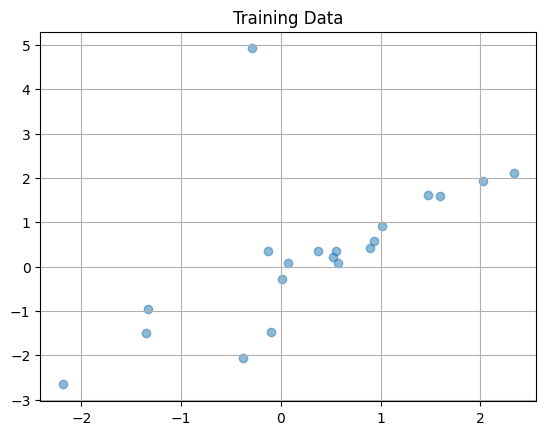

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def generate_data(n_samples=20, input_dim=1, noise_std=0.3):
    """Generate synthetic data with controlled noise and outliers"""
    true_w = torch.ones(input_dim, 1)

    X = torch.randn(n_samples, input_dim)

    # Regular noise
    noise = torch.randn(n_samples, 1) * noise_std

    # Add some outliers
    n_outliers = int(0.2 * n_samples)  # 20% outliers
    outlier_idx = torch.randperm(n_samples)[:n_outliers]
    noise[outlier_idx] *= 10

    y = X @ true_w + noise

    return X, y

def plot_regression(X, y, w):
    """Plot data and regression line"""
    plt.figure(figsize=(10, 6))
    plt.scatter(X[:, 0], y, alpha=0.5, label='Data')

    x_line = torch.linspace(X[:, 0].min(), X[:, 0].max(), 100).reshape(-1, 1)
    y_line = x_line @ w.T

    plt.plot(x_line, y_line, 'r-')
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate some data
X, y = generate_data()

# Let's look at our data
plt.scatter(X, y, alpha=0.5)
plt.title("Training Data")
plt.grid(True)
plt.show()

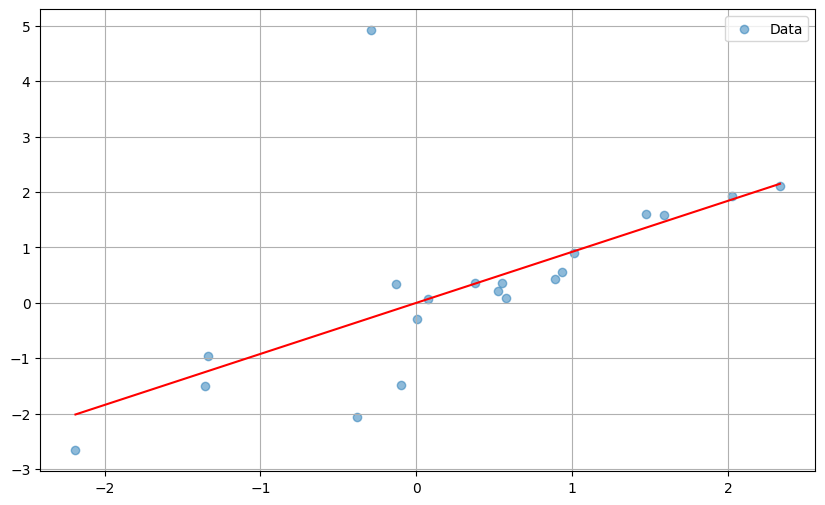

In [19]:
# Now implement your regularized linear regression!
# Remember to derive the solution first on paper.

### fill me! ###
# Define your noise_variance and prior_variance here
# Implement the MAP (maximum a posteriori) solution for w
# Hint: you'll need matrix operations
noise_variance = 0.09 # We take this since we generated our data with noise_std = 0.3
prior_variance = 1 # Since I don't have much information about the weights, I set a large prior

# Once you have your solution, let's visualize it
w = torch.inverse((X.T@X + noise_variance/prior_variance * torch.eye(1))) @ X.T @ y # Your solution here
plot_regression(X, y, w)

# Questions to consider:
# 1. How does your solution handle the outliers?
##### My solution handles outliers using regularisation
# 2. Try changing your noise_variance and prior_variance - what happens?
##### When I lower my prior_variance, the curve flattens, worsening the output weights
##### When I increase noise_variance, the curve also flattens
# 3. What happens if you make either very large or very small?
# for your own sake, think - how would these insights translate or be implemented in more complex settings, e.g. when using a neural network?
##### When noise_variance is very large, it doesn't trust the data, we have low relation between x & y. The curve flattens. NN -> under-fitting
##### When noise_variance is very small, it starts trusting outliers too much. NN -> Over-fitting
##### When prior_variance is very large, we loose regularisation. NN-> Over-fitting
##### When prior_variance is very small, we push weights to zero. NN-> Under-fitting

## Part B - Ensembling as an Approximation of the Predictive Distribution

Although for linear regression we can compute exact solutions for all the distributions we reviewed earlier - as we did in class - typically this isn't the case. One nice but very general approximation we can use is approximating integrals by randomly sampling a few points and summing them up. For example, let's say we're computing the predictive distribution
$$
P(y^*|x^*, D) = \int P(y^*|x^*, M) P(M|D) dM
$$
Given new data $(x^*, y^*)$ and a model $M$, we can calculate $P(y^*|x^*, M)$, but we can't (in general) precisely calculate $P(M|D)$, because we don't have $P(D)$. However, because this integral is an expectation of $P(y^*|x^*, M)$ with respect to $P(M|D)$, we can approximate it using what's known as Monte Carlo sampling. If we can sample different models in a way that's proportional to $P(M|D)$ then we can approximate the integral as a sum.

---
**Q5:** let's first implement the simplest example of a Monte Carlo algorithm, where we randomly sample points to calculate pi. Let's say you randomly draw 2D points in [0,1]$\times$[0,1]. Imagine a quarter unit circle inscribed in that square, so a point falls inside it if $x^2+y^2<1$.  
a. What's the area of that quarter circle? What's the area of that square? What's the area of the quarter circle relative to the square?  
b. Create a short script that randomly draws many points and calculates what percent of them fall in the quarter circle. Use that and (a) to get an estimate of pi.

In [3]:
# fill me!
## a. The area of the quarter circle is pi/4. The area of the square is 1. The quarter circle takes pi/4 of the full square.
nb_data_points = 10**6
circle_points = 0
for i in range(nb_data_points):
  x = np.random.uniform(0,1)
  y = np.random.uniform(0,1)
  if x**2 + y**2 < 1:
    circle_points += 1
ratio_in_circle = circle_points / nb_data_points
pi_approximation = ratio_in_circle * 4
print(f"Percentage of data points that fall in the circle: {ratio_in_circle:.2f}.")
print(f"Approximation of pi: {pi_approximation}")

Percentage of data points that fall in the circle: 0.78.
Approximation of pi: 3.13984


Now, back to the machine learning. In practice, if we draw models properly then we can approximate our predictive distribution as
$$
P(y^*|x^*, D) \approx \frac{1}{n}\sum_{i=1}^n P(y^*|x^*, D, M_i)
$$

This is often known as *ensembling*, when we use several models instead of a single one to get better results. Although quite simple, this is often used to easily get better performance from an existing setup. Historically, most models that won the ILSVRC competitions (colloquially, the ImageNet competitions, where Alexnet made its debut) used some form of ensembling.

On a different note, there's still something we're hiding under the rug - how do we "sample models" properly? This is quite nontrivial and we'll address this properly later on. For now, we'll make do with directly optimising several models and taking them as-is.

---
**Q6:** optimise 3 simple networks to classify MNIST digits. How well do they perform separately vs when ensembled? Make sure you're using a GPU runtime so this'll be quick.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Load and preprocess MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [5]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
def train_model():
    model = MNISTNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    # Training loop
    for epoch in range(3):
        model.train()
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        train_accuracy = 100. * correct / total
        print(f'Epoch {epoch+1}/5: Train Accuracy: {train_accuracy:.2f}%')

    # Test accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    test_accuracy = 100. * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    return model


In [7]:
train_model()

Epoch 1/5: Train Accuracy: 93.06%
Epoch 2/5: Train Accuracy: 97.29%
Epoch 3/5: Train Accuracy: 98.27%
Test Accuracy: 97.72%


MNISTNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [9]:
def ensemble_predict():
    # Train 3 models
    print("Training 3 models for ensemble...")
    models = [train_model() for _ in range(3)]

    # fill me!
    for model in models:
      model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = torch.zeros(target.size(0), 10)
            for model in models:
              output += model(data)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    ensemble_accuracy = 100. * correct / total
    print(f'Ensemble Test Accuracy: {ensemble_accuracy:.2f}%')

In [10]:
ensemble_predict()

Training 3 models for ensemble...
Epoch 1/5: Train Accuracy: 93.08%
Epoch 2/5: Train Accuracy: 97.26%
Epoch 3/5: Train Accuracy: 98.23%
Test Accuracy: 97.86%
Epoch 1/5: Train Accuracy: 93.08%
Epoch 2/5: Train Accuracy: 97.27%
Epoch 3/5: Train Accuracy: 98.20%
Test Accuracy: 97.75%
Epoch 1/5: Train Accuracy: 93.15%
Epoch 2/5: Train Accuracy: 97.27%
Epoch 3/5: Train Accuracy: 98.06%
Test Accuracy: 97.70%
Ensemble Test Accuracy: 98.17%


## Part C (short and sweet) - how should we classify?

Often we want to classify something as belonging to one of two categories, e.g. cats and dogs, 0 or 1, etc. Naturally, a step function is well suited for describing this:
$$
\theta(x) = \begin{cases}
  1 & \text{if } x \geq 0 \\
  0 & \text{if } x < 0
\end{cases}
$$

However, often our inputs are nosiy. Let's say we have Gaussian noise $\epsilon \sim N(0, \sigma^2)$ added to our input x. What does $\theta(x + \epsilon)$ look like? Can you plot it?

### Answer
We want the probability that $x + \varepsilon \geq 0$
This is the same as looking for $P(\varepsilon \geq -x)$
We can then do the following derivation:
$$ P(\varepsilon \geq -x) = 1 - P(\varepsilon < -x)  = 1 - P(\varepsilon \leq -x) = 1 - CDF_\varepsilon(-x) $$

Now, we only have to compute $CDF_\varepsilon$. To do so, we can use the SciPy library.

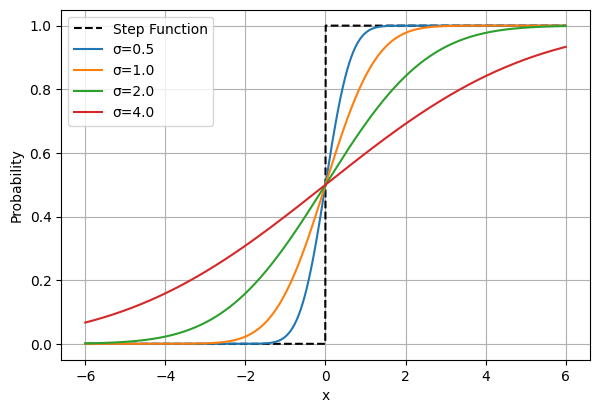

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Create input space
x = np.linspace(-6, 6, 1000)

# Step function (threshold at x=0)
step = np.where(x >= 0, 1, 0)

# Function to compute probability of being above 0 given Gaussian noise
def prob_above_zero(x, noise_std):
    ## fill me!
    return 1 - norm.cdf(-x, loc=0, scale=noise_std)

# Different noise levels
noise_stds = [0.5, 1.0, 2.0, 4.0]

# Create visualization
plt.figure(figsize=(15, 10))

# Plot
plt.subplot(2, 2, 1)
plt.plot(x, step, 'k--', label='Step Function')
for std in noise_stds:
    plt.plot(x, prob_above_zero(x, std), label=f'σ={std}')
plt.xlabel('x')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)


Hmmm, this is starting to look awfully familiar. Let's see if we can leverage this intuition a bit further.

**Q7:** let's try deriving this function analytically, specifically $\mathbb{E}_ϵ[\theta(x+\epsilon)]$ where $\epsilon\sim N(0,\sigma^2)$. What do we get? What would we typically call $\sigma^2$ here?

**A:**
When computing $\mathbb{E}_ϵ[\theta(x+\epsilon)]$, we can disregard the zero as it is a zero factor in the sum. We thus have that
$$\mathbb{E}_ϵ[\theta(x+\epsilon)] = P(x+\epsilon \geq 0) \times 1 = P(\epsilon \geq -x) = 1 - CDF_\epsilon(-x) $$

Using the definition for the CDF or a Gaussian distribution with mean 0 and standard deviation $\sigma$, we get
$$ 1 - CDF_\epsilon(-x) = 1 - \frac{1}{\sigma \sqrt{2\pi}} \int_{-\infty}^{x} \exp\left(-\frac{t^2}{2\sigma^2}\right) \, dt$$

Lastly, here, $\sigma^2$ would be called our variance parameter which models our uncertainty parameter.

**Q8:** Often instead of this function we use a sigmoid instead. Try plotting them both and see how similar - or different - they may look given suitable parameters. Why would we prefer one over the other?

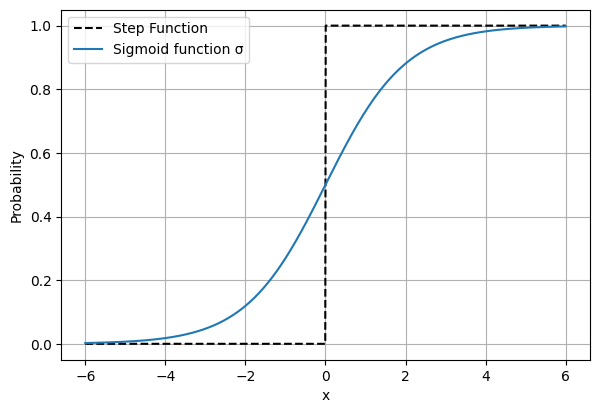

In [3]:
# fill me!
# Taking the code from above

def sigmoid(x):
    ## fill me!
    return 1 / (1 + np.exp(-x))

# Different noise levels
noise_stds = [0.5, 1.0, 2.0, 4.0]

# Create visualization
plt.figure(figsize=(15, 10))

# Plot
plt.subplot(2, 2, 1)
plt.plot(x, step, 'k--', label='Step Function')
plt.plot(x, sigmoid(x), label=f'Sigmoid function σ')
plt.xlabel('x')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)


This sigmoid function looks exactly like the previous curve when we set the noise to $\sigma=1.75$.

We prefer this latter sigmoid approach since it is computationally more straightforward and keeps all of the nice smoothness and differentiability properties.